In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from https://github.com/openai/gym/blob/master/gym/envs/box2d/bipedal_walker.py
def play(env, n_steps=100):
    steps = 0
    total_reward = 0
    a = np.array([0.0, 0.0, 0.0, 0.0])
    STAY_ON_ONE_LEG, PUT_OTHER_DOWN, PUSH_OFF = 1,2,3
    SPEED = 0.29  # Will fall forward on higher speed
    state = STAY_ON_ONE_LEG
    moving_leg = 0
    supporting_leg = 1 - moving_leg
    SUPPORT_KNEE_ANGLE = +0.1
    supporting_knee_angle = SUPPORT_KNEE_ANGLE
    for _ in range(n_steps):
        s, r, done, info = env.step(a)
        total_reward += r
#         if steps % 20 == 0 or done:
#             print("\naction " + str(["{:+0.2f}".format(x) for x in a]))
#             print("step {} total_reward {:+0.2f}".format(steps, total_reward))
#             print("hull " + str(["{:+0.2f}".format(x) for x in s[0:4] ]))
#             print("leg0 " + str(["{:+0.2f}".format(x) for x in s[4:9] ]))
#             print("leg1 " + str(["{:+0.2f}".format(x) for x in s[9:14]]))
        steps += 1

        contact0 = s[8]
        contact1 = s[13]
        moving_s_base = 4 + 5*moving_leg
        supporting_s_base = 4 + 5*supporting_leg

        hip_targ  = [None,None]   # -0.8 .. +1.1
        knee_targ = [None,None]   # -0.6 .. +0.9
        hip_todo  = [0.0, 0.0]
        knee_todo = [0.0, 0.0]

        if state==STAY_ON_ONE_LEG:
            hip_targ[moving_leg]  = 1.1
            knee_targ[moving_leg] = -0.6
            supporting_knee_angle += 0.03
            if s[2] > SPEED: supporting_knee_angle += 0.03
            supporting_knee_angle = min( supporting_knee_angle, SUPPORT_KNEE_ANGLE )
            knee_targ[supporting_leg] = supporting_knee_angle
            if s[supporting_s_base+0] < 0.10: # supporting leg is behind
                state = PUT_OTHER_DOWN
        if state==PUT_OTHER_DOWN:
            hip_targ[moving_leg]  = +0.1
            knee_targ[moving_leg] = SUPPORT_KNEE_ANGLE
            knee_targ[supporting_leg] = supporting_knee_angle
            if s[moving_s_base+4]:
                state = PUSH_OFF
                supporting_knee_angle = min( s[moving_s_base+2], SUPPORT_KNEE_ANGLE )
        if state==PUSH_OFF:
            knee_targ[moving_leg] = supporting_knee_angle
            knee_targ[supporting_leg] = +1.0
            if s[supporting_s_base+2] > 0.88 or s[2] > 1.2*SPEED:
                state = STAY_ON_ONE_LEG
                moving_leg = 1 - moving_leg
                supporting_leg = 1 - moving_leg

        if hip_targ[0]: hip_todo[0] = 0.9*(hip_targ[0] - s[4]) - 0.25*s[5]
        if hip_targ[1]: hip_todo[1] = 0.9*(hip_targ[1] - s[9]) - 0.25*s[10]
        if knee_targ[0]: knee_todo[0] = 4.0*(knee_targ[0] - s[6])  - 0.25*s[7]
        if knee_targ[1]: knee_todo[1] = 4.0*(knee_targ[1] - s[11]) - 0.25*s[12]

        hip_todo[0] -= 0.9*(0-s[0]) - 1.5*s[1] # PID to keep head strait
        hip_todo[1] -= 0.9*(0-s[0]) - 1.5*s[1]
        knee_todo[0] -= 15.0*s[3]  # vertical speed, to damp oscillations
        knee_todo[1] -= 15.0*s[3]

        a[0] = hip_todo[0]
        a[1] = knee_todo[0]
        a[2] = hip_todo[1]
        a[3] = knee_todo[1]
        a = np.clip(0.5*a, -1.0, 1.0)

        env.render()
        if done: 
            env.close()
            break


In [3]:
from bipedal_walker_custom import CustomizableBipedalWalker
env = CustomizableBipedalWalker()

### Pit with fixed width

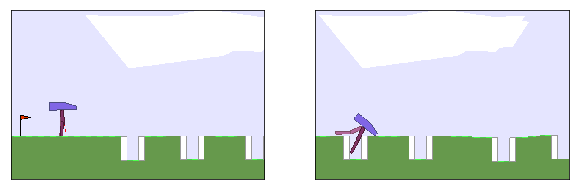

In [4]:
env.set_env_params(pit_width=3)
env.set_env_states(state_mask=np.array([1,0,0,1],dtype=bool), p=np.array([0.1,0,0,0.9]))

f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(env.render(mode='rgb_array'))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

play(env,400)

ax[1].imshow(env.render(mode='rgb_array'))
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

env.close()

### Pit with randomized width

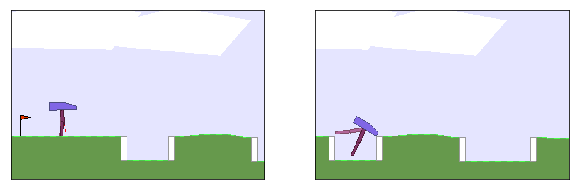

In [5]:
env.set_env_params(pit_width=(2,20))
env.set_env_states(state_mask=np.array([1,0,0,1],dtype=bool), p=np.array([0.1,0.9,0.9,0.9]))

f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(env.render(mode='rgb_array'))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

play(env,400)

ax[1].imshow(env.render(mode='rgb_array'))
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

env.close()

### Stump with fixed height

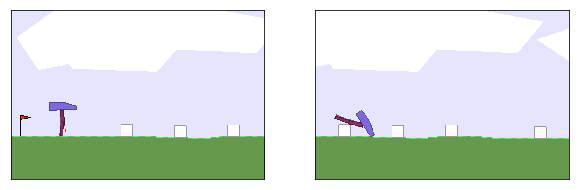

In [6]:
env.set_env_params(stump_height=2)
env.set_env_states(state_mask=np.array([1,1,0,0],dtype=bool), p=np.array([0.1,0.9,0.9,0.9]))

f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(env.render(mode='rgb_array'))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

play(env,400)

ax[1].imshow(env.render(mode='rgb_array'))
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

env.close()

### Stump with randomized height

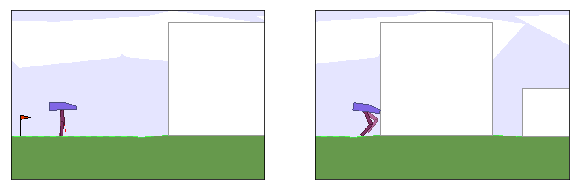

In [8]:
env.set_env_params(stump_height=(2,20))
env.set_env_states(state_mask=np.array([1,1,0,0],dtype=bool), p=np.array([0.1,0.9,0.9,0.9]))

f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(env.render(mode='rgb_array'))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

play(env,400)

ax[1].imshow(env.render(mode='rgb_array'))
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

env.close()

### Allow only pits and stairs with default parameters

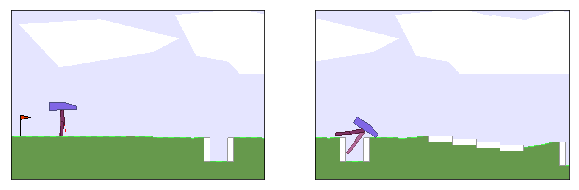

In [10]:
env.reset_env_params()
env.set_env_states(state_mask=np.array([1,0,1,1],dtype=bool))

f, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(env.render(mode='rgb_array'))
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

play(env,400)

ax[1].imshow(env.render(mode='rgb_array'))
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

env.close()